In [ ]:
import time
import json
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from loader_clone import create_loaders


In [2]:

import numpy as np
import pandas as pd

class EASE():
    """Implementation of EASE algorithm for EasyStudy using closed-form solution
    paper: https://arxiv.org/abs/1905.03375


    Internally, we assign binary ratings during training as that is the way it
    was done in the paper. As an alternative, we could predict the ratings, as
    is also mentioned in the paper.
    """

    def __init__(self, loader, positive_threshold, l2, **kwargs):
        self._ratings_df = None
        self._loader = loader
        self._all_items = None

        self._rating_matrix = None

        self._threshold = positive_threshold
        self._l2 = l2

        self._items_count = None

        self._weights = None

    # One-time fitting of the algorithm for a predefined number of iterations
    def fit(self, loader):
        print("FITTING EASE")

        self._loader = loader

        self._ratings_df = loader.ratings_df

        self._all_items = self._ratings_df.item.unique()

        self._rating_matrix = (
            self._loader.ratings_df.pivot(index="user", columns="item", values="rating")
            .fillna(0)
            .values
        )

        self._items_count =  np.shape(self._rating_matrix)[1]

        X = np.where(self._rating_matrix >= self._threshold, 1, 0).astype(np.float32)

        # Compute Gram matrix (G = X^T @ X)
        G = X.T @ X
        G += self._l2 * np.eye(self._items_count)  # Regularization

        # Compute the inverse of G
        P = np.linalg.inv(G)

        # Compute B matrix
        diag_P = np.diag(P)
        B = P / (-diag_P[:, None])  # Normalize rows by diagonal elements
        np.fill_diagonal(B, 0)  # Set diagonal to zero
        print("B matrix computed")
        self._weights = B

    # Predict for the user
    def predict(self, selected_items, filter_out_items, k, div_perception):
        rat = pd.DataFrame({"item": selected_items}).set_index("item", drop=False)
        # Appropriately filter out what was seen and what else should be filtered
        candidates = np.setdiff1d(self._all_items, rat.item.unique())
        candidates = np.setdiff1d(candidates, filter_out_items)
        if not selected_items:
            # Nothing was selected, since the new_user was unknown during training, Lenskit algorithm would simply recommended nothing
            # to avoid empty recommendation, we just sample random candidates
            return np.random.choice(candidates, size=k, replace=False).tolist()
        indices = list(selected_items)
        user_vector = np.zeros((self._items_count,), dtype=np.float32)
        for i in indices:
            user_vector[i] = 1.0

        preds = np.dot(user_vector, self._weights)

        preds = np.abs(preds)  

        candidates_by_prob = sorted(
            ((preds[cand], cand) for cand in candidates), reverse=True
        )
        result = [x for _, x in candidates_by_prob][:k]


        return result

In [3]:
_, loader = create_loaders()

(1525, 384) (1525, 384)
(9456, 384) (9456, 384)
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456


In [4]:
# mapping for filtered dataset...
movie_ids = sorted(loader.ratings_df.movieId.unique())
id2idx = {mid: i for i, mid in enumerate(movie_ids)}
idx2id = {i: mid for mid, i in id2idx.items()}

# rename cols as in EasyStudy and map movieId to indices
ratings_mapped = (
    loader.ratings_df
    .rename(columns={"userId": "user",
                     "movieId": "item",
                     "rating": "rating"})
    .assign(item=lambda x: x["item"].map(id2idx))
    [["user", "item", "rating"]]
    .astype({"user": int, "item": int, "rating": float})
    .reset_index(drop=True)
)

loader.ratings_df = ratings_mapped

print(ratings_mapped.head())


   user  item  rating
0    16    74     1.0
1    16    86     1.5
2    16   213     1.0
3    16   313     2.0
4    16   347     1.0


In [5]:
# Split the dataset into train and validation set
train_df, val_df = train_test_split(
    ratings_mapped, test_size=0.2, stratify=ratings_mapped["user"], random_state=42 # stratify -> ensures that users are represented in both train and validation sets
)

# Ease works with collaborative data only
class MiniLoader:
    def __init__(self, ratings_df):
        self.ratings_df = ratings_df.copy()

train_loader = MiniLoader(train_df)
val_loader   = MiniLoader(val_df)


In [6]:
def precision_recall_f1_at_k(model, train_df, val_df, k=10, n_users=100):
    users_all = val_df.user.unique()
    users_sample = np.random.choice(users_all,
                                    size=min(n_users, len(users_all)),
                                    replace=False)

    hits = 0      
    total_pred = 0 
    total_true = 0

    for u in users_sample:
        true_items = val_df[val_df.user == u]["item"].tolist()
        seen_items = train_df[train_df.user == u]["item"].tolist()

        recs = model.predict(
            selected_items=seen_items,
            filter_out_items=seen_items,
            k=k,
            div_perception=None
        )

        hits += len(set(recs) & set(true_items))
        total_pred += k
        total_true += len(true_items)

    precision = hits / total_pred if total_pred else 0.0
    recall = hits / total_true if total_true else 0.0
    f1 = 0.0 if precision + recall == 0 else 2*precision*recall/(precision+recall)
    return precision, recall, f1


In [ ]:
L2_GRID = [5, 10, 50, 100, 250, 500, 1000]
K_AT = 20
N_USERS = 100
N_REPEATS = 3
POSITIVE_THRESHOLD = 2.5
SAVE_PATH = "tuning_results.json"

def tune_ease_l2(
    train_loader,
    train_df,
    val_df,
    l2_grid,
    k,
    n_users,
    n_repeats,
    threshold,
    save_path
):
    results = []
    plot_axis = {"l2": [], "prec": [], "rec": [], "f1": []}

    for l2 in l2_grid:
        algo = EASE(loader=train_loader, positive_threshold=threshold, l2=l2)

        t0 = time.perf_counter()
        algo.fit(train_loader)
        fit_time = time.perf_counter() - t0

        prec_runs, rec_runs, f1_runs = [], [], []
        for _ in range(n_repeats):
            p, r, f = precision_recall_f1_at_k(
                algo, train_df=train_df, val_df=val_df,
                k=k, n_users=n_users
            )
            prec_runs.append(p)
            rec_runs.append(r)
            f1_runs.append(f)

        p_avg = np.mean(prec_runs)
        r_avg = np.mean(rec_runs)
        f_avg = np.mean(f1_runs)

        results.append({
            "l2": l2,
            "precision": round(p_avg, 4),
            "recall": round(r_avg, 4),
            "f1": round(f_avg, 4),
            "fit_time_s": round(fit_time, 3)
        })

        plot_axis["l2"].append(l2)
        plot_axis["prec"].append(p_avg)
        plot_axis["rec"].append(r_avg)
        plot_axis["f1"].append(f_avg)

        print(f"l2={l2:>6} │ fit={fit_time:5.2f}s │ "
              f"P={p_avg:.3f}  R={r_avg:.3f}  F1={f_avg:.3f}")

    with open(save_path, "w") as fp:
        json.dump(results, fp, indent=4)

    best_entry = max(results, key=lambda d: d["f1"])
    print(f"\nBest l2 (F1) -> {best_entry['l2']} "
          f"(P={best_entry['precision']:.3f}, "
          f"R={best_entry['recall']:.3f}, "
          f"F1={best_entry['f1']:.3f}, "
          f"fit={best_entry['fit_time_s']:.2f}s)")

    return results, plot_axis, best_entry

In [ ]:
results, plot_axis, best_entry = tune_ease_l2(
    train_loader=train_loader,
    train_df=train_df,
    val_df=val_df,
    l2_grid=L2_GRID,
    k=K_AT,
    n_users=N_USERS,
    n_repeats=N_REPEATS,
    threshold=POSITIVE_THRESHOLD,
    save_path=SAVE_PATH
)



In [45]:
def plot_tuning_results(plot_axis):
    plt.figure(figsize=(7, 4))
    
    l2_values = plot_axis["l2"]
    
    plt.plot(l2_values, plot_axis["prec"], marker="o", label="Precision")
    plt.plot(l2_values, plot_axis["rec"],  marker="s", label="Recall")
    plt.plot(l2_values, plot_axis["f1"],   marker="^", label="F1")
    
    plt.xscale("log")
    plt.xticks(l2_values, labels=[str(l2) for l2 in l2_values])  # Set exact tick positions and labels
    
    plt.xlabel("Lambda")
    plt.ylabel("Score")
    plt.title("EASE lambda hyperparameter tuning")
    plt.legend()
    plt.tight_layout()
    plt.show()


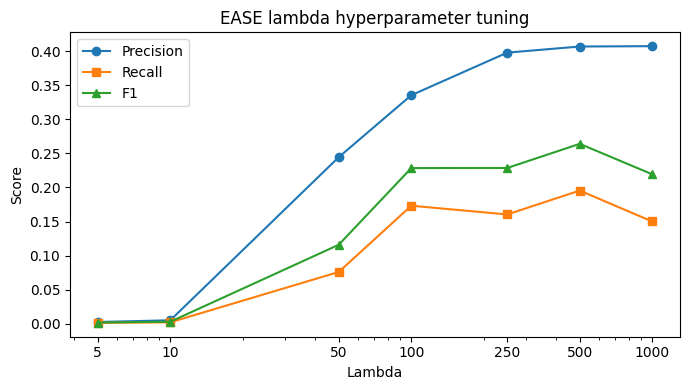

In [44]:
plot_tuning_results(plot_axis)